In [1]:
import seaborn as sns

In [4]:
sns.color_palette("deep")

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [5]:
list(sns.color_palette("deep"))

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [2]:
import numpy as np
import trimesh
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorboard as tb
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import cv2
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

path_to_results = "./benchmarking/2/results/"
path_to_rewards = "./benchmarking/2/rewards/"

In [3]:
!ls ./benchmarking/2/results

image  image_time  internal


* single column
(3.5 inches / 88 millimeters / 21 picas) or 
* page wide 
(7.16 inches / 181 millimeters / 43 picas). 
* depth
maximum 8.5 inches (216 millimeters / 54 picas).
* dpi
600

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({
    "text.usetex": False,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    # plt.rcParams['pdf.fonttype'] = 42 # if type-1 font
    'figure.dpi': 300,
    'lines.linewidth': 1,
    'grid.linewidth': 0.2,
    'grid.linestyle': "--",
    'font.size': SMALL_SIZE,          # controls default text sizes
    'axes.titlesize': SMALL_SIZE,     # fontsize of the axes title
    'axes.labelsize': SMALL_SIZE,    # fontsize of the x and y labels
    'xtick.labelsize': SMALL_SIZE,    # fontsize of the tick labels
    'ytick.labelsize': SMALL_SIZE,    # fontsize of the tick labels
    'legend.fontsize': SMALL_SIZE,    # legend fontsize
    'figure.titlesize': BIGGER_SIZE,  # fontsize of the figure title
})

# for figures

In [5]:
# defaults
def make_size(width=3.5, aspect_ratio=(21,9)):
    # cinema 21,9
    # widescreen 16,9
    # classic 4,3
    # single 3.5
    # double 7.16
    return (width, width * aspect_ratio[1] / aspect_ratio[0])

single_column_size = 3.3
double_column_size = 7.06

single_column_square = make_size(single_column_size, aspect_ratio=(1,1))
single_column_4_3 = make_size(single_column_size, aspect_ratio=(4,3))
single_column_16_9 = make_size(single_column_size, aspect_ratio=(16,9))
single_column_cinema = make_size(single_column_size, aspect_ratio=(21,9))
double_column_cinema = make_size(double_column_size, aspect_ratio=(16,9))
double_column_hd = make_size(double_column_size, aspect_ratio=(21,9))

In [6]:
!ls 

assets		environment.yml    MUJOCO_LOG.TXT	 train_algorithms.py
benchmarking	main_her.py	   __pycache__		 train_her.py
cathsim_her.py	main.ipynb	   README.md		 train_off_policy.py
cathsim.py	main.py		   scratch.backup.ipynb  train.py
data		mujoco_env_her.py  scratch.ipynb	 utils.py
data.zip	mujoco_env.py	   test_algorithms.py	 visualise.py


In [7]:
data = np.load("./benchmarking/1_test/results/image_time/ppo-1-lcca-CnnPolicy.npz",allow_pickle=True)
for key, values in data.items():
    print(key)

forces = data['forces']
print(len(forces))

forces
rewards
max_forces
successes
6466636


## Quantitative: Table

In [15]:
env = "2"
path_results = f"./benchmarking/{env}/results"

def create_dataset(path):
    data = {"Aorta":[], "Observation":[], "Target":[], "Algorithm": [], "Reward":[], "Force":[], "Max Force":[], "Success": []}
    for observation_type in os.listdir(path):
        for filename in os.listdir(os.path.join(path,observation_type)):
            observation= observation_type.replace("_"," ").title()
            splitted_filename = os.path.splitext(filename)[0]
            splitted_filename = splitted_filename.split("-")
            if splitted_filename[0] == "a2c" and (observation == "Image" or observation == "Image Time") and splitted_filename[3][:-6] == "Mlp":
                pass
            else:
                results = np.load(os.path.join(path, observation_type, filename), allow_pickle=True)
                reward = int(np.mean(results['rewards']))
                reward_std = int(np.std(results['rewards']))
                force = np.mean(results['forces'])
                force_std = np.std(results['forces'])
                max_force = np.mean(results['max_forces'])
                max_force_std = np.std(results['max_forces'])
                if observation == "Image Time":
                    observation = "Sequential"
                data['Algorithm'].append(splitted_filename[0].upper())
                data['Observation'].append(observation)
    #             data['Algorithm'].append(splitted_filename[0].upper())
                data['Aorta'].append(splitted_filename[1])
                data['Target'].append(splitted_filename[2].upper())
#                 data['Policy'].append(splitted_filename[3][:-6])
                data['Reward'].append(f'{reward} pm {reward_std}')
                data['Force'].append(f'{force:.3f} pm {force_std:.3f}')
                data['Max Force'].append(f'{max_force:.3f} pm {max_force:.3f}')
                data['Success'].append(np.mean(results['successes']))
            
            
    return data
data = create_dataset(path_results)
# for key, value in data.items():
#     print(key, len(value))
df = pd.DataFrame(data)
df = df.sort_values(by=["Aorta", "Observation", "Target", "Algorithm", ])
print(df.to_latex(buf=None, columns=None, col_space=None, header=True, index=False, na_rep='NaN', formatters=None, 
                  float_format=None, sparsify=None, index_names=True, bold_rows=True, column_format=None, longtable=None, 
                  escape=None, encoding=None, decimal='.', multicolumn=None, multicolumn_format=None, multirow=True, caption="Results Summary", label="tab:1", position="th"))

\begin{table}[th]
\centering
\caption{Results Summary}
\label{tab:1}
\begin{tabular}{lllllllr}
\toprule
Aorta & Observation & Target & Algorithm &      Reward &          Force &      Max Force &  Success \\
\midrule
    1 &       Image &    BCA &       PPO &   -65 pm 52 & 0.005 pm 0.007 & 0.048 pm 0.048 &     0.83 \\
    1 &       Image &    BCA &       SAC & -391 pm 157 & 0.024 pm 0.035 & 0.258 pm 0.258 &     0.00 \\
    1 &       Image &   LCCA &       PPO &  -140 pm 96 & 0.007 pm 0.016 & 0.076 pm 0.076 &     0.37 \\
    1 &       Image &   LCCA &       SAC &   -196 pm 5 & 0.003 pm 0.003 & 0.059 pm 0.059 &     0.00 \\
    1 &    Internal &    BCA &       PPO &   -70 pm 28 & 0.011 pm 0.021 & 0.121 pm 0.121 &     0.53 \\
    1 &    Internal &    BCA &       SAC &   -54 pm 36 & 0.007 pm 0.014 & 0.059 pm 0.059 &     0.77 \\
    1 &    Internal &   LCCA &       PPO &  -154 pm 66 & 0.008 pm 0.015 & 0.123 pm 0.123 &     0.07 \\
    1 &    Internal &   LCCA &       SAC &  -158 pm 83 & 0.006 

/tmp/ipykernel_73476/3305983829.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(buf=None, columns=None, col_space=None, header=True, index=False, na_rep='NaN', formatters=None,


# Qualitative

In [8]:
def make_dataset(path, kind="Rewards"):
    df = {"Observation": [], "Aorta":[],"Target":[],"Policy":[], kind.replace("_", " ").title():[]}
    for observation in os.listdir(path):
        files_path = os.path.join(path, observation)
        for file in os.listdir(files_path):
            file_path_full = os.path.join(path, observation, file)
            data = np.load(file_path_full, allow_pickle=True)
            splitted =file.split("-")
            splitted[-1] = splitted[-1][:3]
            obs = "Sequential" if observation == "image_time" else observation
            for key, values in data.items():
                if key == kind:
                    for value in values:
#                         print(obs)
                        df["Observation"].append(obs.replace("_"," ").title())
                        df["Aorta"].append(splitted[1])
                        df["Target"].append(splitted[2].upper())
                        df["Policy"].append(splitted[3].capitalize())
                        df[kind.replace("_"," ").title()].append(value)
    return pd.DataFrame(df)

df = make_dataset(path_to_results, kind="rewards")
df["Observation"].unique()

array(['Internal', 'Sequential', 'Image'], dtype=object)

In [ ]:
def make_boxplot(env="2", kind="max_forces", aorta="1", policy="Mlp", legend=False):
    path = f"./benchmarking/{env}/results/"
    image_path = f"./benchmarking/{env}/figures/{aorta}"
    df = make_dataset(path, kind)
    df = df[(df["Aorta"]==aorta)]
    plot = sns.catplot(x="Target", y="Max Forces", hue="Observation", data=df, kind="box", palette="deep", legend=legend,
                       height=3, aspect=1.2, hue_order=["Internal", "Image", "Sequential"], order=["BCA", "LCCA"])
    plt.ylim((0,0.5))
    plt.legend(frameon=False)
#     plt.savefig(image_path, format="svg")
make_boxplot(env="2", kind="max_forces")


/home/tudorjnu/.miniconda3/envs/cathsim/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


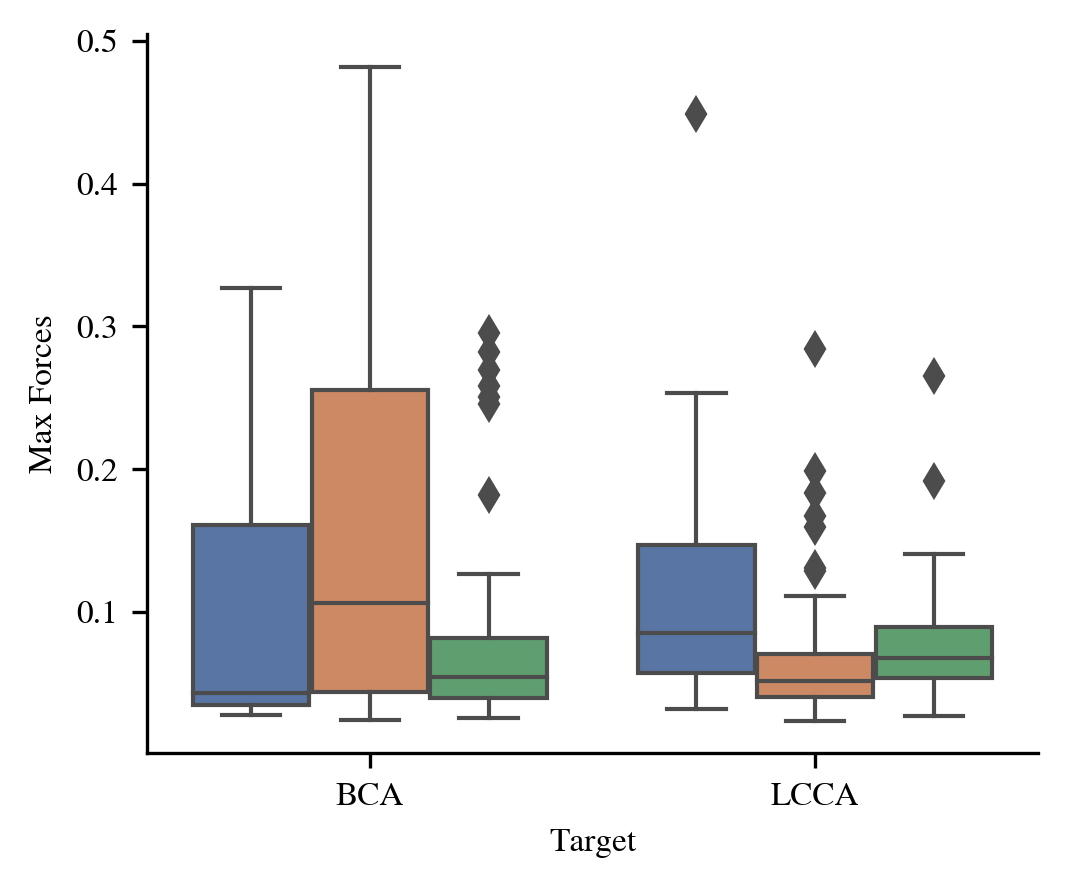

In [21]:
def make_boxplot(env="2", kind="max_forces", aorta="1", legend=False, aspect=0.9,ax=0):
    path = f"./benchmarking/{env}/results/"
    df = make_dataset(path, kind)
    df = df[(df["Aorta"]==aorta)]
    ax = sns.catplot(x="Target", y="Max Forces", hue="Observation", data=df, kind="box", 
                     height=3, aspect=aspect, order=["BCA","LCCA"],hue_order=["Internal", "Image", "Sequential"], 
                     legend=legend, palette="deep",ax=ax)
    return ax

plot = make_boxplot(aspect=1.2, legend=False)

## Boxplot

In [10]:
df = make_dataset(path_to_results, kind="forces")

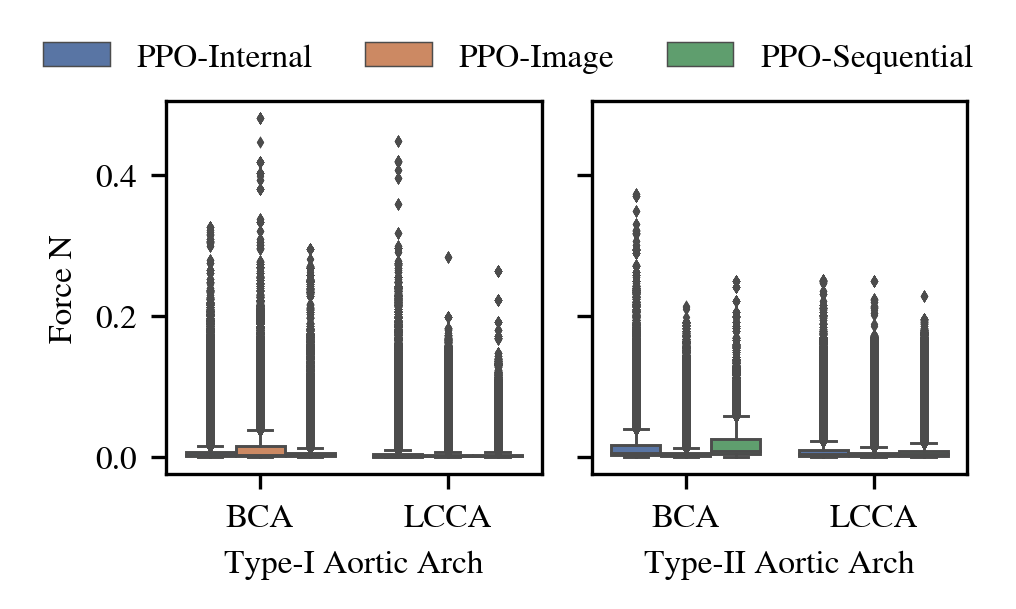

In [13]:

def make_boxplot(df, env="2",y="Forces", aorta="1", aspect=1,ax=0):
    save_path = f"./benchmarking/{env}/figures/boxplot.pdf"
    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=single_column_16_9, squeeze=True)
    path = f"./benchmarking/{env}/results/"
    #     df = df[df["Policy"]=="Mlp"]
    sns.boxplot(x="Target",y="Forces", hue="Observation", data=df[df["Aorta"]=="1"], order=["BCA","LCCA"],
                hue_order=["Internal", "Image", "Sequential"], palette="deep",ax=axs[0], orient="v", linewidth=0.7, fliersize=0.7)
    sns.boxplot(x="Target",y="Forces", hue="Observation", data=df[df["Aorta"]=="2"], order=["BCA","LCCA"],
                hue_order=["Internal", "Image", "Sequential"], palette="deep",ax=axs[1], orient="v", linewidth=0.7, fliersize=0.7)

    axs[0].set(ylabel="Force N", xlabel="Type-I Aortic Arch")
    handles, labels = axs[0].get_legend_handles_labels()    
    
    axs[1].set(ylabel=None, xlabel="Type-II Aortic Arch")
    
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()
    for i, label in enumerate(labels):
        labels[i] = "PPO-"+label
    legend = fig.legend(handles, labels, loc='upper center', ncol=3, mode="expand", bbox_to_anchor=(0., 0.98, 1., .102), frameon=False)
    plt.tight_layout()
    plt.savefig(save_path, bbox_extra_artists=[legend,], bbox_inches='tight')
    
make_boxplot(df)

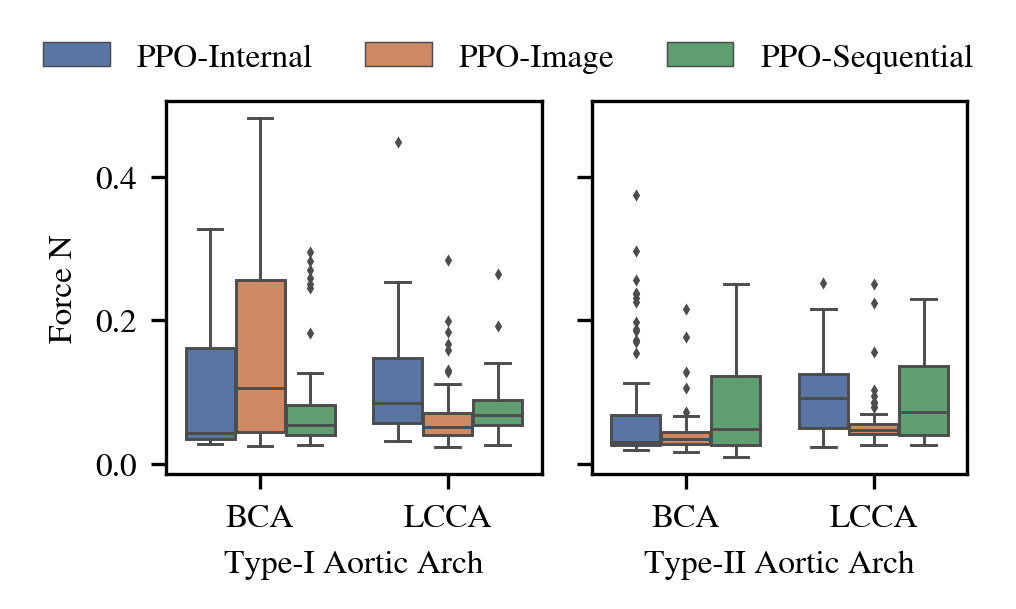

In [15]:
from matplotlib.legend import _get_legend_handles_labels

def make_boxplot(env="2",kind="max_forces", aorta="1", aspect=1,ax=0):
    save_path = f"./benchmarking/{env}/figures/boxplot.png"
    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=single_column_16_9, squeeze=True)
    path = f"./benchmarking/{env}/results/"
    df = make_dataset(path, kind)
#     df = df[df["Policy"]=="Mlp"]
    sns.boxplot(x="Target",y="Max Forces", hue="Observation", data=df[df["Aorta"]=="1"], order=["BCA","LCCA"],
                hue_order=["Internal", "Image", "Sequential"], palette="deep",ax=axs[0], orient="v", linewidth=0.7, fliersize=0.7)
    sns.boxplot(x="Target",y="Max Forces", hue="Observation", data=df[df["Aorta"]=="2"], order=["BCA","LCCA"],
                hue_order=["Internal", "Image", "Sequential"], palette="deep",ax=axs[1], orient="v", linewidth=0.7, fliersize=0.7)

    axs[0].set(ylabel="Force N", xlabel="Type-I Aortic Arch")
    handles, labels = axs[0].get_legend_handles_labels()    
    
    axs[1].set(ylabel=None, xlabel="Type-II Aortic Arch")
    
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()
    for i, label in enumerate(labels):
        labels[i] = "PPO-"+label
    legend = fig.legend(handles, labels, loc='upper center', ncol=3, mode="expand", bbox_to_anchor=(0., 0.98, 1., .102), frameon=False)
    plt.tight_layout()
    plt.savefig(save_path, bbox_extra_artists=[legend,], bbox_inches='tight')
    
make_boxplot(kind="max_forces")

## Heatmap

In [34]:


#img = cv2.imread('./Heatmap/aorta_image.png', 0)
img = cv2.imread('./Heatmap/aorta.png', 0)[:,:, np.newaxis]
img = np.tile(img,3)

force_img = cv2.imread('./Heatmap/force.png', 0)
force_img2 = cv2.imread('./Heatmap/force2.png', 0)
#force_img = (force_img + force_img2) 
force_img = (force_img + force_img2)
heatmap_img = cv2.applyColorMap(force_img, cv2.COLORMAP_JET)

fin = cv2.addWeighted(heatmap_img, 0.8, img, 0.3, 0)
plt.imshow(fin)
plt.axis(False)

[ WARN:0@14395.900] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./Heatmap/aorta.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

In [408]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('./data/Figures/Heatmap/aorta_1/aorta.png', 0)
img = np.where(img>=150,255,img)[:,:, np.newaxis]
img = np.tile(img,3)
force_img = cv2.imread('./Heatmap/aorta_1/force.png', 0)
force_img2 = cv2.imread('./Heatmap/aorta_1/force2.png', 0)
#force_img = (force_img + force_img2) 
force_img = (force_img + force_img2)

heatmap_img = cv2.applyColorMap(force_img, cv2.COLORMAP_TURBO)
fin = np.where(force_img[:,:,np.newaxis]==0, img, heatmap_img)
plt.imshow(fin, alpha=1)
plt.axis(False)

[ WARN:0@71902.122] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data/Figures/Heatmap/aorta_1/aorta.png'): can't open/read file: check file path/integrity


TypeError: '>=' not supported between instances of 'NoneType' and 'int'

In [387]:
img = cv2.imread('./Heatmap/aorta_2/aorta.png', 0)[:,:, np.newaxis]
img = np.where(img>=215, 255, img)

img = np.tile(img,3)
force_img1 = cv2.imread('./Heatmap/aorta_2/force_1.png', 0)
force_img2 = cv2.imread('./Heatmap/aorta_2/force_4.png', 0)
force_img3 = cv2.imread('./Heatmap/aorta_2/force_5.png', 0)
force_img = (force_img1 + force_img2 + force_img3)
force_img = np.mean(np.array([force_img1, force_img2, force_img3]), axis=0)
cv2.imwrite('./Heatmap/aorta_2/force.png', force_img)
force_img = cv2.imread('./Heatmap/aorta_2/force.png', 0)
heatmap_img = cv2.applyColorMap(force_img, cv2.COLORMAP_JET)
print(heatmap_img.max())
# plt.imshow(heatmap_img)
fin = cv2.addWeighted(heatmap_img, 0.7, img, 0.3, 0)
fin = np.where(force_img[:,:,np.newaxis]==0, img, fin)

plt.imshow(fin, alpha=1)
plt.axis(False)

[ WARN:0@71550.239] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./Heatmap/aorta_2/aorta.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

In [388]:
img = cv2.imread('./Heatmap/aorta_1.png', 0)
img = np.where(img>=150, 255, img+80)[:,:, np.newaxis]
img = np.tile(img,3)

force_img = cv2.imread('./Heatmap/scene_1_lca/force.png', 0)
heatmap_img = cv2.applyColorMap(force_img, cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.7, img, 0.3, 0)
tilled_force = np.tile(force_img[:,:,np.newaxis],3)
fin = np.where(tilled_force==30, img, heatmap_img)


plt.imshow(img, alpha=0.8)
plt.axis(False)

[ WARN:0@71553.295] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./Heatmap/aorta_1.png'): can't open/read file: check file path/integrity


TypeError: '>=' not supported between instances of 'NoneType' and 'int'

## Heatmap

In [9]:
img = cv2.imread('./Heatmap/aorta_2.png', 0)
img = np.where(img>=215, 255, img)[:,:, np.newaxis]
img = np.tile(img,3)

force_img = cv2.imread('./Heatmap/scene_2_bca/force.png', 0)
heatmap_img = cv2.applyColorMap(force_img, cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.7, img, 0.3, 0)
tilled_force = np.tile(force_img[:,:,np.newaxis],3)
fin = np.where(tilled_force==30, img, heatmap_img)

plt.imshow(img, alpha=0.8)
plt.axis(False)

[ WARN:0@534.110] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./Heatmap/aorta_2.png'): can't open/read file: check file path/integrity


TypeError: '>=' not supported between instances of 'NoneType' and 'int'

(0.0, 1.0, 0.0, 1.0)

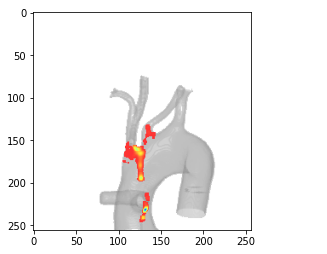

In [10]:
img = cv2.imread('./data/Figures/Heatmap/aorta_2.png', 0)
img = np.where(img>=215, 255, img)[:,:, np.newaxis]
img = np.tile(img,3)

force_img = cv2.imread('./data/Figures/Heatmap/internal/scene_2_bca/force.png', 0)
heatmap_img = cv2.applyColorMap(force_img, cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.7, img, 0.3, 0)
tilled_force = np.tile(force_img[:,:,np.newaxis],3)
fin = np.where(tilled_force==30, img, heatmap_img)


plt.imshow(fin, alpha=0.8)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(force_img, cax=cax)
plt.axis(False)

(-0.5, 255.5, 255.5, -0.5)

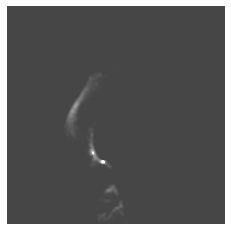

In [6]:
img = cv2.imread('./Heatmap/aorta_image.png', 0)
img = np.where(img>=150,255,img)[:,:, np.newaxis]
img = np.tile(img,3)
img = np.where(img<240, img+40, img)
plt.imshow(img)
plt.axis(False)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

a_1_bca_force = np.load("./benchmarking/distance_1/results/internal/PPO_scene_1_bca_MlpPolicy.npz", allow_pickle=True)['all_forces']
a_1_lca_force = np.load("./benchmarking/distance_1/results/internal/PPO_scene_1_lca_MlpPolicy.npz", allow_pickle=True)['all_forces']
a_2_bca_force = np.load("./benchmarking/distance_1/results/internal/PPO_scene_2_bca_MlpPolicy.npz", allow_pickle=True)['all_forces']
a_2_lca_force = np.load("./benchmarking/distance_1/results/internal/PPO_scene_2_lca_MlpPolicy.npz", allow_pickle=True)['all_forces']

In [10]:
a_1_bca_force.shape

(23125,)

ValueError: List of boxplot statistics and `positions` values must have same the length

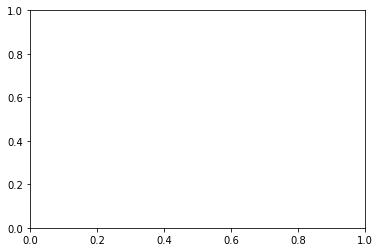

In [12]:
import matplotlib.pyplot as plt
import numpy as np

data_a = a_1_bca_force
data_b = a_1_lca_force

ticks = ['A', 'B', 'C']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(data_a.shape[0]))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(data_b.shape[0]))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Apples')
plt.plot([], c='#2C7BB6', label='Oranges')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('boxcompare.png')

# Reward Plots

In [17]:
def make_reward_data(env="2"):
    df = { "Observation": [], "Aorta": [], "Target": [], "Step": [], "Value": []}
#     fig, ax = plt.subplots(2,2, figsize=(10,10))
    path = f"./benchmarking/{env}/rewards/"
    for filename in os.listdir(path):
        file = os.path.join(path, filename)
        filename = filename.split("-")[0:4]
        algorithm = filename[1].upper()
        observation = filename[0]
        if observation == "image_time":
            observation = "Sequential"
        observation = observation.title()
        aorta = filename[2]
#         aorta = "Type-I" if aorta == "1" else "Type-II"
        target = filename[3].upper()
        data = np.genfromtxt(file, delimiter=',')
        for row in data[1:]:
            df["Step"].append(row[1])
            df["Value"].append(row[2])
            df["Aorta"].append(aorta)
            df["Target"].append(target)
            df["Observation"].append(f'{algorithm}-{observation}')
    return pd.DataFrame(df)
df = make_reward_data()
df = df[df["Step"] <= 600000]
df = df.sort_values(by=["Aorta", "Target", "Step", "Observation"])
df

,Observation,Aorta,Target,Step,Value
1492,SAC-Image,1,BCA,8000.0,-429.291626
2747,SAC-Internal,1,BCA,8000.0,-429.291626
690,SAC-Sequential,1,BCA,8000.0,-429.291626
0,PPO-Image,1,BCA,8192.0,-422.397827
1927,PPO-Internal,1,BCA,8192.0,-319.540710
...,...,...,...,...,...
1490,PPO-Internal,2,LCCA,598016.0,-202.296021
1200,PPO-Sequential,2,LCCA,598016.0,-19.581066
1670,SAC-Internal,2,LCCA,598056.0,-97.452919
1671,SAC-Internal,2,LCCA,599680.0,-95.320663


In [42]:
df.describe()

,Step,Value
count,2830.000000,2830.000000
mean,312818.956890,-216.766143
std,173026.878989,116.846731
min,8000.000000,-472.924500
25%,163732.000000,-318.084557
50%,319488.000000,-215.323380
75%,464968.000000,-114.490549
max,600000.000000,-0.957260


/home/tudorjnu/.miniconda3/envs/cathsim/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/tudorjnu/.miniconda3/envs/cathsim/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/tudorjnu/.miniconda3/envs/cathsim/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

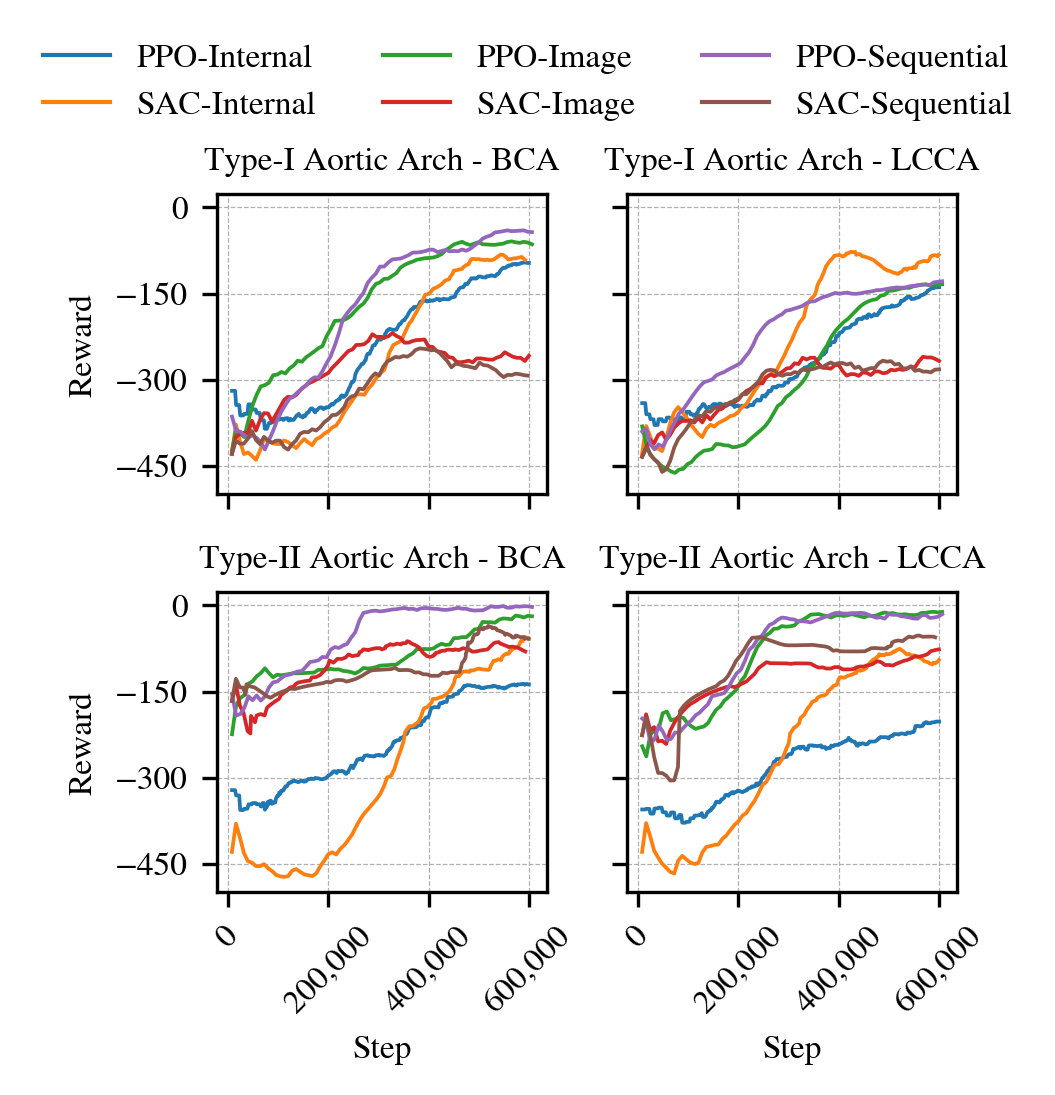

In [18]:
def plot_reward_all(env="2", color_palette="deep"):
    df = make_reward_data(env)
    fig_savepath = f"./benchmarking/{env}/figures/rewards.png"
    
    algorithms = ["PPO-Internal", "PPO-Image","PPO-Image Time","SAC-Internal", "SAC-Image","SAC-Image Time"]
    color_palette = sns.color_palette(color_palette, n_colors=len(algorithms))
    colors = dict(zip(algorithms, color_palette))
    
    titles = {"1": "Type-I Aortic Arch", "2": "Type-II Aortic Arch"}
    fig, ax = plt.subplots(2,2, figsize=single_column_square, sharex=True, sharey=True, squeeze=True)

    bca_1 =  df[(df["Aorta"]=="1") & (df["Target"]=="BCA")]
    bca_2 =  df[(df["Aorta"]=="2") & (df["Target"]=="LCCA")]
    lcca_1 = df[(df["Aorta"]=="1") & (df["Target"]=="BCA")]
    lcca_2 = df[(df["Aorta"]=="2") & (df["Target"]=="LCCA")]
    data_frames = [bca_1, lcca_1, bca_2, lcca_2]
    for j, target in enumerate(["BCA", "LCCA"]):
        for i, aorta in enumerate(["1","2"]):
            data = df[(df["Aorta"]==aorta) & (df["Target"]==target)]
            sns.lineplot("Step", "Value", data=data, hue='Observation', linewidth=0.9,
                         hue_order=["PPO-Internal","SAC-Internal", "PPO-Image", "SAC-Image", "PPO-Sequential", "SAC-Sequential"], ax=ax[i,j], legend=True)
            handles, labels = ax[i,j].get_legend_handles_labels()
            ax[i,j].get_legend().remove()
            ax[i,j].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            ax[i,j].tick_params(axis='x', labelrotation = 45)
            ax[i,j].set_xlabel("Step", ) 
            ax[i,j].set_ylabel("Reward",)
            ax[i,j].set_xticks(np.arange(0, 800000, 200000), rotation=45)
            ax[i,j].set_yticks(np.arange(-500, 100, 100))
            ax[i,j].grid(linestyle='--', linewidth=0.3)
            ax[i,j].title.set_text(titles[aorta] +f" - {target}")
    
    

    # For every axis, set the x and y major locator
    for axi in ax.flat:
        axi.xaxis.set_major_locator(plt.MaxNLocator(4))
        axi.yaxis.set_major_locator(plt.MaxNLocator(4))
    legend = fig.legend(handles, labels, loc='upper center', ncol=3, borderaxespad=0., bbox_to_anchor=(0., 0.98, 1., .102), frameon=False)
    plt.tight_layout()
    
    plt.savefig(fig_savepath,bbox_extra_artists=[legend,], bbox_inches='tight')
    plt.show()

plot_reward_all()

In [ ]:
def plot_reward(aorta, target, df=df):
    
    df = df[(df["Aorta"]==aorta) & (df["Target"]==target)]
    sns.lineplot("Step", "Value", data=df, hue='Observation', hue_order=["Internal", "Image","Image Time"])
    plt.legend(loc="lower right")
    plt.xlabel("Steps")
    plt.xticks(np.arange(0, 800000, 200000))
    plt.yticks(np.arange(-800, 200, 200))
    plt.ylabel("Reward")
    plt.grid(linestyle='dotted')
    plt.show()
